In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 15, 6

In [2]:
df_fx_data = pd.read_csv(r'C:\Users\saqla\Desktop\Python Certification for Data Science\In Class Practice Codes\13. Module 13\M13_toupload\BOE-XUDLERD.csv')
df_fx_data

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608
...,...,...
10832,1975-01-08,0.7554
10833,1975-01-07,0.7510
10834,1975-01-06,0.7524
10835,1975-01-03,0.7585


In [3]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])
indexed_df = df_fx_data.set_index('Date')
ts = indexed_df['Value']
ts.head(5)

Date
2017-11-09    0.8603
2017-11-08    0.8631
2017-11-07    0.8639
2017-11-06    0.8631
2017-11-03    0.8608
Name: Value, dtype: float64

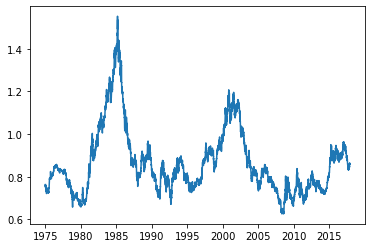

In [4]:
plt.plot(ts)

### Daily data has too much variation and also has missing values. So resampling by week.

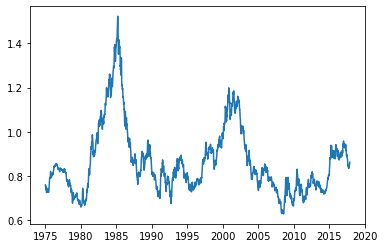

In [5]:
ts_week = ts.resample('W').mean()
plt.plot(ts_week)

### Check for Stationarity

#### The hypotheses for the Dickey Fuller test:
#### The null hypothesis for this test is that there is a unit root i.e the data is not stationary
#### The alternate hypothesis differs slightly according to which equation you’re using. The basic alternate is that the time series is stationary (or trend-stationary).

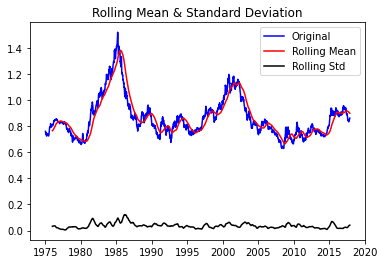

Results of Dickey-Fuller Test:
Test Statistic                   -2.076341
p-value                           0.254134
#Lags Used                        2.000000
Number of Observations Used    2234.000000
Critical Value (1%)              -3.433281
Critical Value (5%)              -2.862835
Critical Value (10%)             -2.567459
dtype: float64


In [6]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts_week)

In [7]:
# for key,value in dftest[4].items():
        #dfoutput['Critical Value (%s)'%key] = value

# (-2.076340599933052, 0.2541339550926488, 2, 2234, {'1%': -3.4332805415364724, '5%': -2.8628346299364282, '10%': -2.5674591931002038}, -14013.954809290073)

### Stationarize the time series

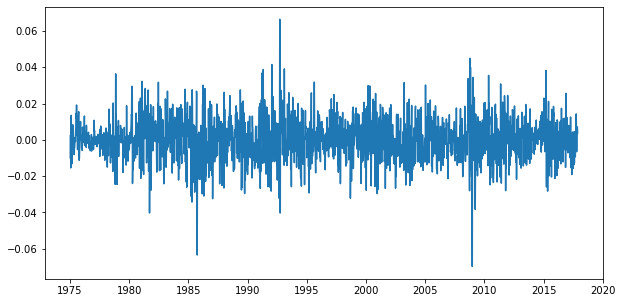

In [8]:
ts_week_log = np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.figure(figsize=(10,5))
plt.plot(ts_week_log_diff)

In [9]:
ts_week_log

Date
1975-01-05   -0.273253
1975-01-12   -0.283079
1975-01-19   -0.280428
1975-01-26   -0.295876
1975-02-02   -0.302430
                ...   
2017-10-15   -0.166905
2017-10-22   -0.164898
2017-10-29   -0.158691
2017-11-05   -0.151567
2017-11-12   -0.147804
Freq: W-SUN, Name: Value, Length: 2237, dtype: float64

In [10]:
ts_week_log.iloc[0]

-0.2732533357996601

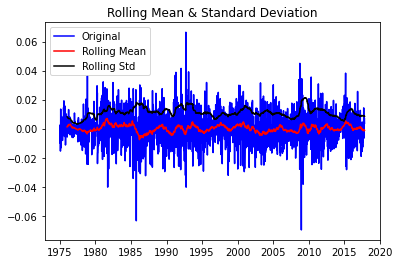

Results of Dickey-Fuller Test:
Test Statistic                  -36.590004
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2235.000000
Critical Value (1%)              -3.433279
Critical Value (5%)              -2.862834
Critical Value (10%)             -2.567459
dtype: float64


In [11]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

### Since the time series is stationarized ARIMA model can be applied 

In [12]:
#ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags=10)                   # gives 'q' value
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')   # gives 'p' value

D:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function')

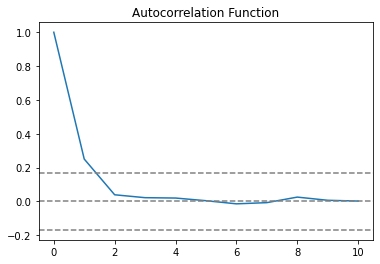

In [13]:
#Plot ACF: The lag value in the ACF chart where the line crosses the upper CI for the first time. We can see q=1 here.
#plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

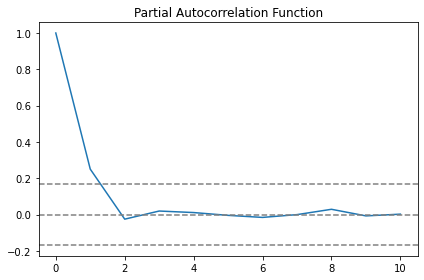

In [14]:
#Plot PACF: The lag value where the PACF cuts off (drops to 0) for the first time. We can see p=2 here.
#plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: 0.2806')

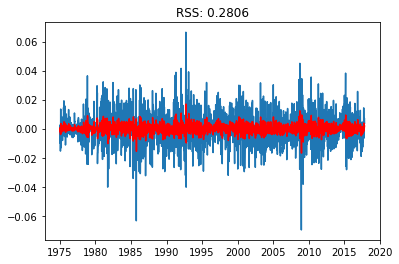

In [15]:
model = ARIMA(ts_week_log, order=(2, 1, 1))   # order(p,d,f)
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 15 Jun 2021   AIC                         -13731.202
Time:                        15:47:26   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.51e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0902      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128     

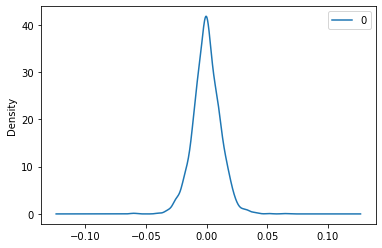

In [16]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [17]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
1975-01-12    0.000055
1975-01-19   -0.002420
1975-01-26    0.000987
1975-02-02   -0.004103
1975-02-09   -0.001134
Freq: W-SUN, dtype: float64


### Now that the model is returning results, we are scaling the model predictions back to the original scale.

Text(0.5, 1.0, 'RMSE: 0.1353')

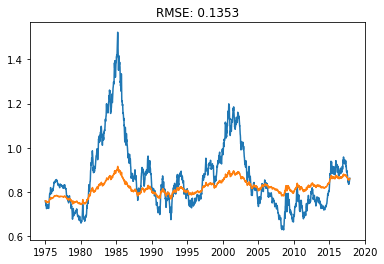

In [18]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

### Training and Testing Datasets

In [19]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

### Training the model and forecasting

In [20]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...




D:\Anaconda\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.860853, expected=0.862600


In [21]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.000043


### Forecasted vs Observed Plot

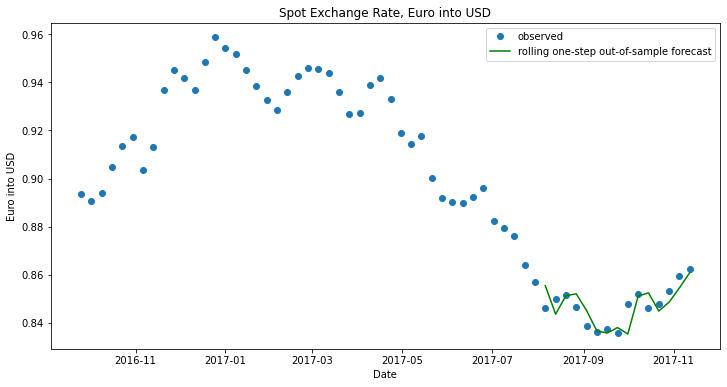

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')